In [1]:
import pandas as pd
import numpy as np
from scipy import stats

# Load data
df = pd.read_csv('../data/MachineLearningRating_v3.txt', delimiter='|')  

# Create binary claim indicator
df['has_claim'] = df['TotalClaims'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\HP\AppData\Local\Temp\ipykernel_18736\1571637268.py:6: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MachineLearningRating_v3.txt', delimiter='|')


In [2]:
# ANOVA test for claim severity across provinces
provinces = df['Province'].unique()
severity_by_province = [df[df['Province']==p]['TotalClaims'].dropna() for p in provinces]
f_stat, p_val = stats.f_oneway(*severity_by_province)

# Chi-square for claim frequency
contingency = pd.crosstab(df['Province'], df['has_claim'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)

In [4]:
# Select top 2 most common zip codes for comparison
top_zips = df['PostalCode'].value_counts().index[:2]
zip1_data = df[df['PostalCode']==top_zips[0]]
zip2_data = df[df['PostalCode']==top_zips[1]]

# T-test for claim severity
t_stat, p_val = stats.ttest_ind(zip1_data['TotalClaims'].dropna(),
                               zip2_data['TotalClaims'].dropna(),
                               equal_var=False)

# Proportion test for claim frequency
from statsmodels.stats.proportion import proportions_ztest
count = [zip1_data['has_claim'].sum(), zip2_data['has_claim'].sum()]
nobs = [len(zip1_data), len(zip2_data)]
z_stat, p_val = proportions_ztest(count, nobs)

In [5]:
# Using same zip codes as above
t_stat, p_val = stats.ttest_ind(zip1_data['TotalPremium']-zip1_data['TotalClaims'],
                               zip2_data['TotalPremium']-zip2_data['TotalClaims'],
                               equal_var=False)

In [6]:
# T-test for claim severity
male_claims = df[df['Gender']=='Male']['TotalClaims'].dropna()
female_claims = df[df['Gender']=='Female']['TotalClaims'].dropna()
t_stat, p_val = stats.ttest_ind(male_claims, female_claims, equal_var=False)

# Proportion test for claim frequency
count = [df[df['Gender']=='Male']['has_claim'].sum(),
        df[df['Gender']=='Female']['has_claim'].sum()]
nobs = [len(df[df['Gender']=='Male']), len(df[df['Gender']=='Female'])]
z_stat, p_val = proportions_ztest(count, nobs)

In [8]:
# Run your tests and STORE the p-values first:

# For Hypothesis 1 (Provinces)
_, p_val_province_severity = stats.f_oneway(*severity_by_province)  # From ANOVA
_, p_val_province_frequency, _, _ = stats.chi2_contingency(contingency)  # From Chi2

# For Hypothesis 2 (Zip codes - risk)
_, p_val_zip_risk_severity = stats.ttest_ind(zip1_data['TotalClaims'].dropna(),
                                           zip2_data['TotalClaims'].dropna(),
                                           equal_var=False)
_, p_val_zip_risk_frequency = proportions_ztest(count, nobs)  # From earlier

# For Hypothesis 3 (Zip codes - margin)
_, p_val_zip_margin = stats.ttest_ind(zip1_data['TotalPremium']-zip1_data['TotalClaims'],
                                    zip2_data['TotalPremium']-zip2_data['TotalClaims'],
                                    equal_var=False)

# For Hypothesis 4 (Gender)
_, p_val_gender_severity = stats.ttest_ind(male_claims, female_claims, equal_var=False)
_, p_val_gender_frequency = proportions_ztest(count, nobs)  # From earlier

In [10]:
results = pd.DataFrame({
    'Hypothesis': [
        'No risk differences across provinces (severity)',
        'No risk differences across provinces (frequency)',
        'No risk differences between zip codes (severity)',
        'No risk differences between zip codes (frequency)',
        'No margin differences between zip codes',
        'No risk differences between genders (severity)',
        'No risk differences between genders (frequency)'
    ],
    'Test Type': ['ANOVA', 'Chi2', 'T-test', 'Proportion', 'T-test', 'T-test', 'Proportion'],
    'p-value': [
        p_val_province_severity,
        p_val_province_frequency,
        p_val_zip_risk_severity,
        p_val_zip_risk_frequency,
        p_val_zip_margin,
        p_val_gender_severity,
        p_val_gender_frequency
    ],
    'Conclusion': ['Reject' if p < 0.05 else 'Fail to reject' for p in [
        p_val_province_severity,
        p_val_province_frequency,
        p_val_zip_risk_severity,
        p_val_zip_risk_frequency,
        p_val_zip_margin,
        p_val_gender_severity,
        p_val_gender_frequency
    ]]
})

In [11]:
# Example for gender severity difference
mean_diff = male_claims.mean() - female_claims.mean()
pooled_std = np.sqrt((male_claims.std()**2 + female_claims.std()**2)/2)
cohens_d = mean_diff / pooled_std

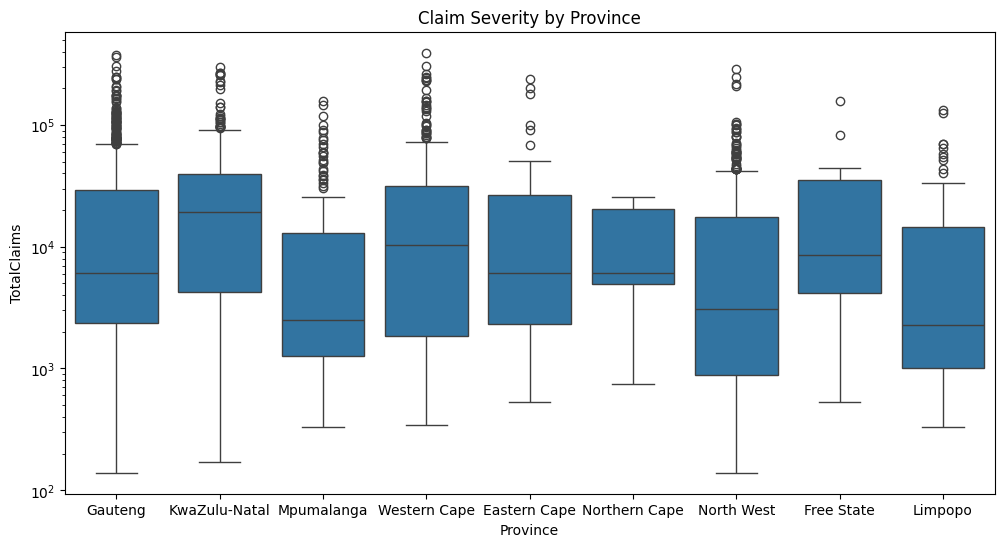

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of claim amounts by province
plt.figure(figsize=(12,6))
sns.boxplot(x='Province', y='TotalClaims', data=df[df['TotalClaims']>0])
plt.title('Claim Severity by Province')
plt.yscale('log')
plt.show()